#ML notes

### By Amin Rigi



Australian Energy Market Operator (AEMO) is a not-for-profit organisation partly owned by federal and state governments, with members from electricity and gas generation, transmission, distribution, retail and resources businesses across Australia. According to AMEO 2019 annual report, their target is to achieve short-term and long-term electricity demand forecast accuracy within 3% and 5% of actual peak demand, respectively.

Machine Learning Task: ‌‌‌‌Building a predictive system 



In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive # importing data from my colab

drive.mount('/content/gdrive')

# reading from google drive
df = pd.read_csv("/content/gdrive/My Drive/aminFiles/PRICE_AND_DEMAND_201903_VIC1.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## A bit of data analysis

In [4]:
df.head(5)

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,VIC1,2019/03/01 00:30:00,5262.60,112.17,TRADE
1,VIC1,2019/03/01 01:00:00,5060.04,112.75,TRADE
2,VIC1,2019/03/01 01:30:00,4893.86,115.77,TRADE
3,VIC1,2019/03/01 02:00:00,4757.79,98.77,TRADE
4,VIC1,2019/03/01 02:30:00,4674.41,83.10,TRADE


In [2]:
df.describe()

,TOTALDEMAND,RRP
count,1488.000000,1488.000000
mean,4858.360383,131.111223
std,866.302331,510.109827
min,3399.000000,7.460000
25%,4271.842500,82.492500
50%,4669.925000,104.955000
75%,5223.790000,120.232500
max,9289.500000,12634.810000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6785f3b70>,
      dtype=object)

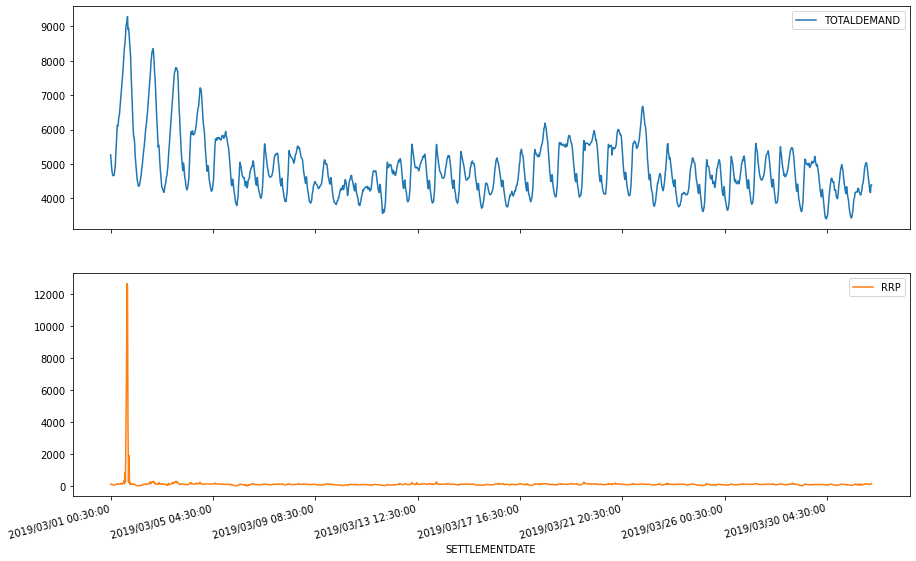

In [5]:
df.plot(x="SETTLEMENTDATE", y=["TOTALDEMAND", "RRP"], figsize=(15,10), rot = 15, subplots=True)

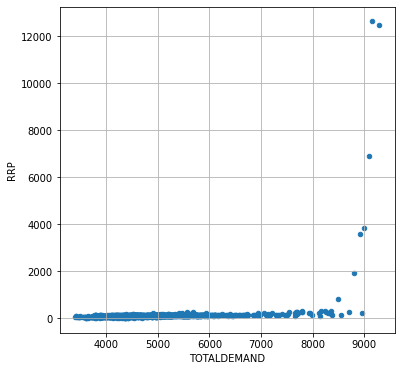

In [6]:
df.plot.scatter( x = 'TOTALDEMAND', y = 'RRP', figsize = (6, 6),  grid = True)

Focusing on the scatter plot by ignoring outliers

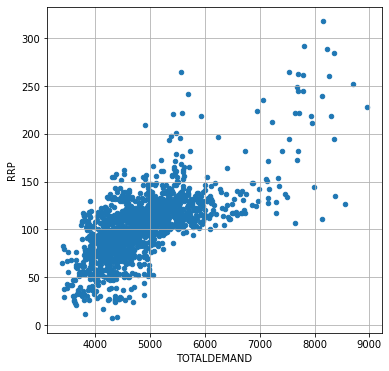

In [9]:
df = df[df['RRP']<500]
df.plot.scatter( x = 'TOTALDEMAND', y = 'RRP', figsize = (6, 6),  grid = True)

Having a look at pair plot

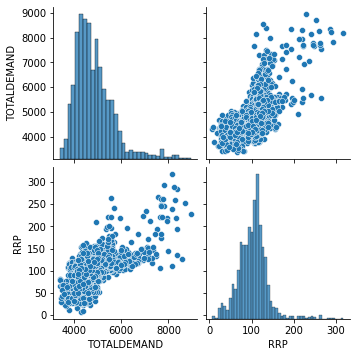

In [13]:
sns.pairplot(df);

### Data prepration

Defiging the required functions

In [15]:
def normalise_data(df):
    """
    Description: normalise totaldemand data
    Input: df
    Output: 
        X: an array (time series) of normalised_demand
    """
    data_demand = df["TOTALDEMAND"].to_numpy().reshape(-1, 1)
    
    scaler_demand = StandardScaler()
    scaler_demand.fit(data_demand)
    X = scaler_demand.transform(data_demand)
    
    return X, scaler_demand

In [18]:
def Vec2Mat(V, din, dout):
    import numpy as np
    """
    V: input vector, shape(N,1), numpy array/ 2D Matrix
    din:  input demensionality. datatype: integer 
    dout: output demensionality. datatype: integer
    M: matrix with shape (N-din, din+dout)
    """
    V = V.reshape(-1,1)
    N, p = V.shape
    din =  np.uint32(din)
    dout = np.uint32(dout)
    if N<din+dout or p !=1:
        print(f"check {din}+{dout}>={N} ?")
        print(f"check {p} == 1 ?")
        return "[ERROR] Check: Row din+dout <=Number and V should be column matrix"
    M = np.zeros([N-din-dout+1, din+dout])
    for i in range(N-din-dout+1) :
        M[i,:] = V[i:din+dout + i].flat # add the window to the output matrix
    return M

In [19]:
def generate_dataset(df, n_dim_in, n_dim_out, test_ratio):
    """
    Description: Split training and testing data based on the input test_ratio by order. First part is assigned to train set and last part is assigned to test part.
    Input:
        + df_data: data in data frame format includes target in last column, features in remain columns.
        + test_ratio
    Output: X_train, y_train, X_test, y_test
    """    
    X_demand, scaler_demand = normalise_data(df)
    # convert vector to array n_dim (number of previous demands used to predict)
    M_demand = Vec2Mat(X_demand, n_dim_in, n_dim_out)
    #print(M_demand.shape)
    n_row, n_col = M_demand.shape

    X = M_demand[:,0:n_col-1]
    y = M_demand[:,-1]

    train_ratio = 1-test_ratio
    n_train = int(n_row*train_ratio)

    # extract train data
    X_train = X[0:n_train][:]
    y_train = y[0:n_train][:]

    # extract test data
    X_test = X[n_train+1:-1][:]
    y_test = y[n_train+1:-1][:]
    print("Training samples:")
    print(str(X_train.shape))
    print("Testing samples:")
    print(str(X_test.shape))
    return X_train, y_train, X_test, y_test, scaler_demand

In [22]:
def mean_absolute_error(y_true, y_pred): 
    # or from sklearn.metrics import mean_absolute_error.
    y_true, y_pred = np.array(y_true), np.array(y_pred)  
    errors = np.abs(y_true - y_pred)
    return np.mean(errors)

In [23]:
def mean_absolute_percentage_error(y_true, y_pred):  # be carefully with the zero division issues!!!
    y_true, y_pred = np.array(y_true), np.array(y_pred) # list to array
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Breaking into test and train

In [21]:
from sklearn.preprocessing import StandardScaler
test_ratio = 0.15
n_dim_in = 12
n_dim_out = 1
X_train, y_train, X_test, y_test, scaler_demand = generate_dataset(df,n_dim_in,n_dim_out,test_ratio)

Training samples:
(1248, 12)
Testing samples:
(219, 12)


Linear Regression

In [27]:
from sklearn import linear_model # Required package
import numpy as np
model = linear_model.LinearRegression()
model.fit(X_train,y_train)

# Testing
y_pred = model.predict(X_test)

# Evaluation
mean_abs_err     = mean_absolute_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))
mean_abs_per_err = mean_absolute_percentage_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))
print("Loss: Absolute error: %.4f" % mean_abs_err)
print("Loss: Absolute percentage error: %.4f %% " % mean_abs_per_err)

Loss: Absolute error: 63.1056
Loss: Absolute percentage error: 1.4179 % 


## Neural Networks: 

### Multi-layer Perceptron Model (MLP)¶

In [31]:
from sklearn.neural_network import MLPRegressor
# init a model
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='relu', solver = 'sgd',
                                 alpha = 0.0001,
                                 batch_size=32,
                                 learning_rate_init=0.001,
                                 max_iter = 1000, verbose = False,
                                 early_stopping=True)
# train the model
model.fit(X_train, y_train)

# predict from trained model
y_pred = model.predict(X_test)


mean_abs_err = mean_absolute_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))
mean_abs_per_err = mean_absolute_percentage_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))

print("Loss: Absolute error: %.4f" % mean_abs_err)
print("Loss: Absolute percentage error: %.4f %% " % mean_abs_per_err)

Loss: Absolute error: 79.0904
Loss: Absolute percentage error: 1.8115 % 


### MLP/Deep learning with tensorflow-**keras**

Feature shape: (12,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,251
Trainable params: 3,251
Non-trainable params: 0
_________________________________________________________________


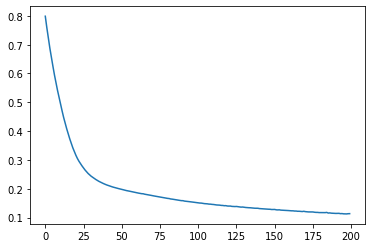

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers


# input shape
input_shape = (X_train.shape[1],)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(layers.Dense(50, input_shape=input_shape, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.summary()

# Configure the model and start training
model.compile(loss='mae', optimizer='sgd', metrics=['mae','mse'])
history = model.fit(X_train, y_train, epochs=200, batch_size=1024, verbose=0)
plt.plot(history.history['loss'])

In [41]:
# convert the shape of the output to be the same with the shape of y_test. IT IS IMPORTANT TO USE FLATTEN() function
y_pred = model.predict(X_test).flatten()

mean_abs_err = mean_absolute_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))
mean_abs_per_err = mean_absolute_percentage_error(scaler_demand.inverse_transform(y_test),scaler_demand.inverse_transform(y_pred))

print("Loss: Absolute error: %.4f" % mean_abs_err)
print("Loss: Absolute percentage error: %.4f %% " % mean_abs_per_err)

Loss: Absolute error: 88.3371
Loss: Absolute percentage error: 1.9861 % 
